# Data Pre-Processing and Visualization

### Import Required Libraries

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
import math

### Custom Functions Used for Processing and Information Parsing

#### Calculating Trip Time from Polyline (deriving output labels)

- Points are taken at 15 second intervals, thus the formula for travel time is:

    (numpoints - 1)*15s 

In [2]:
def travel_time(polyline):
    return max(polyline.count("[") - 2, 0) * 15

#### Parsing Timestamp into constituent Components

In [3]:
def parse_timestamp(taxi_data):
    date_time = datetime.fromtimestamp(taxi_data["TIMESTAMP"])
    return date_time.year, date_time.month, date_time.day, date_time.hour, date_time.weekday()

#### Deriving Velocity from Polyline

In [4]:
#Velocity Calculation adapted from: 
#https://www.ridgesolutions.ie/index.php/2013/11/14/algorithm-to-calculate-speed-from-two-gps-latitude-and-longitude-points-and-time-difference/

def velocity(lat1, lon1, lat2, lon2):
    
    #Convert degrees to radians
    lat1 = lat1 * math.pi / 180.0;
    lon1 = lon1 * math.pi / 180.0;
    lat2 = lat2 * math.pi / 180.0;
    lon2 = lon2 * math.pi / 180.0;
    
    #radius of earth in metres
    r = 6378100;
    
    #P
    rho1 = r * math.cos(lat1)
    z1 = r * math.sin(lat1)
    x1 = rho1 * math.cos(lon1)
    y1 = rho1 * math.sin(lon1)
    
    #Q
    rho2 = r * math.cos(lat2)
    z2 = r * math.sin(lat2)
    x2 = rho2 * math.cos(lon2)
    y2 = rho2 * math.sin(lon2)
    
    #Dot product
    dot = (x1 * x2 + y1 * y2 + z1 * z2)
    cos_theta = dot / (r * r)
    
    if(cos_theta > 1):
        cos_theta = 1
        
    theta = math.acos(cos_theta)
    
    #Distance in Metres
    distance = r * theta
    
    return distance/15 #speed in meters per second

#### Computing Average Velocities from Velcoity Data

In [5]:
avg_velocities = []
coordinate_list = []

#Average Velocity
def avg_velo(taxi_data):
    
    k = 10
    
    poly = taxi_data["POLYLINE"]
    
    for i in range(0, len(taxi_data), 1):
        coord = poly[i]
        coord = re.split(r',|\[|\]', coord)
        count = 0
        
        coordinates = []
        
        for value in coord:
            if (count > 2*(k-2) or count > len(coord)-2):
                break
            else:
                #print(value + str(value.isnumeric()))
                if(value != ''):
                    coordinates.append(float(value))
                    
        coordinate_list.append(coordinates)
              
        velocities = []
        
        for j in range(0, int(len(coordinates)/4), 1):
            velocities.append(velocity(coordinates[j], coordinates[j+1], coordinates[j+2], coordinates[j+3]))
    
        sum_velo = 0.0
    
        for velo in velocities:
            sum_velo += velo
        
        if(len(velocities)==0):
            num_velo = 1
        else:
            num_velo = len(velocities)
            
        avg_velocities.append(sum_velo/num_velo)

### Read CSV Dataset File

In [6]:
taxi_data = pd.read_csv("kaggle_data/train.csv")

### Text Based Data Visulization

In [7]:
#Display first 5 Lines
taxi_data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [8]:
#Dataset Size
taxi_data.shape

(1710670, 9)

In [9]:
#Dataset Information Type
taxi_data.columns

Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'POLYLINE'],
      dtype='object')

In [10]:
#Find number of empty datacells by information type
taxi_data.isnull().sum()

TRIP_ID               0
CALL_TYPE             0
ORIGIN_CALL     1345900
ORIGIN_STAND     904091
TAXI_ID               0
TIMESTAMP             0
DAY_TYPE              0
MISSING_DATA          0
POLYLINE              0
dtype: int64

#### Travel Time Calculation from Polyline

In [11]:
#Add trip duration to dataset
taxi_data["LEN"] = taxi_data["POLYLINE"].apply(travel_time)

In [12]:
#Split timestamp into individual columns
taxi_data[["YR", "MON", "DAY", "HR", "WK"]] = taxi_data[["TIMESTAMP"]].apply(parse_timestamp, axis=1, result_type="expand")

#### Baseline Prediction Model with Statistics

In [13]:
mean_duration = taxi_data["LEN"].mean()
standard_deviation = taxi_data["LEN"].std()
median = taxi_data["LEN"].median()

print(f"{mean_duration=}\n{median=}\n{standard_deviation=}")

mean_duration=716.4264615618442
median=600.0
standard_deviation=684.7511617510816


### Distribution Plots 

#### Data Cleaning is necessary for effective data visualization

In [14]:
outlier_threshold = 3
total_size = len(taxi_data)
temp_taxi_data = taxi_data[taxi_data["LEN"] < mean_duration + outlier_threshold * standard_deviation]
print(f"Using: {len(temp_taxi_data)}/{total_size}")
trimmed_taxi_data = temp_taxi_data[temp_taxi_data["MISSING_DATA"] == False]
print(f"Using: {len(trimmed_taxi_data)}/{total_size}")

Using: 1692771/1710670
Using: 1692763/1710670


#### Trip Time

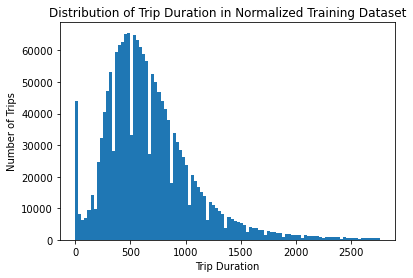

In [15]:
duration = trimmed_taxi_data["LEN"].tolist()
plt.hist(duration, bins=100)
plt.xlabel('Trip Duration')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trip Duration in Normalized Training Dataset')
plt.savefig("time_dist.png")

#### Month, Day and Hour

Text(0.5, 1.0, 'Distribution of Trips Across Years')

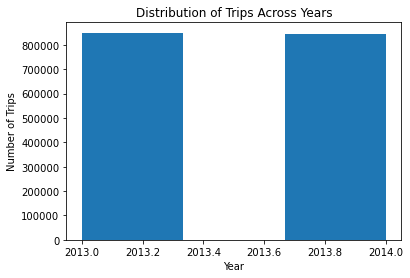

In [23]:
#Year

year = trimmed_taxi_data["YR"].tolist()

plt.hist(year, bins = 3)
plt.xlabel('Year')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips Across Years')

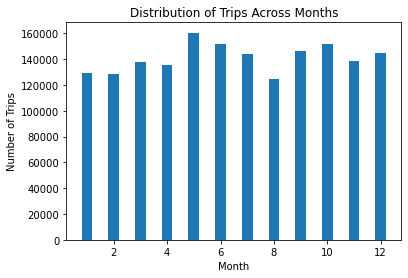

In [16]:
#Month
month = trimmed_taxi_data["MON"].tolist()

month_vis = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
for trip in month:
    month_vis[trip] += 1
    
months = list(month_vis.keys())
num_trips = list(month_vis.values())
    
plt.bar(months, num_trips, width = 0.4)
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips Across Months')
plt.savefig("month_dist.png")

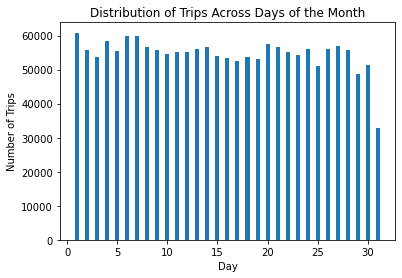

In [17]:
#Day
day = trimmed_taxi_data["DAY"].tolist()

day_vis = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0, 21:0, 22:0, 23:0, 24:0, 25:0, 26:0, 27:0, 28:0, 29:0, 30:0, 31:0}
for trip in day:
    day_vis[trip] += 1
    
days = list(day_vis.keys())
num_trips = list(day_vis.values())
    
plt.bar(days, num_trips, width = 0.4)
plt.xlabel('Day')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips Across Days of the Month')
plt.savefig("day_dist.png")

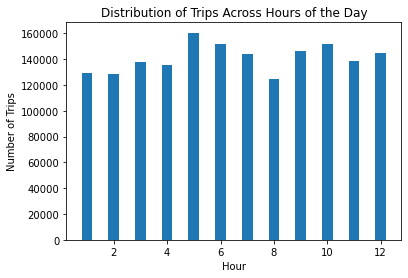

In [18]:
#Hour
hr = trimmed_taxi_data["MON"].tolist()

hr_vis = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
for trip in hr:
    hr_vis[trip] += 1
    
hrs = list(hr_vis.keys())
num_trips = list(hr_vis.values())
    
plt.bar(hrs, num_trips, width = 0.4)
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips Across Hours of the Day')
plt.savefig("hr_dist.png")

### Velocity Distribution

Velocity was derived from the POLYLINE field of the training data and is used to train a model to predict velocity which is then used to predict trip duration

In [19]:
trimmed_taxi_data.reset_index(drop=True, inplace=True)
avg_velo(trimmed_taxi_data)

In [20]:
avg_velo_df = pd.DataFrame({'velocity':avg_velocities})

mean_velocity = avg_velo_df.mean()
standard_deviation_velo = avg_velo_df.std()
median_velo = avg_velo_df.median()

print(f"{mean_velocity=}\n{median_velo=}\n{standard_deviation_velo=}")

outlier_threshold = 3
total_size = len(avg_velocities)
trimmed_velo = avg_velo_df[avg_velo_df["velocity"] < 50]
print(f"Using: {len(trimmed_velo)}/{total_size}")

mean_velocity=velocity    6.87536
dtype: float64
median_velo=velocity    6.150449
dtype: float64
standard_deviation_velo=velocity    25.872258
dtype: float64
Using: 1691242/1692763


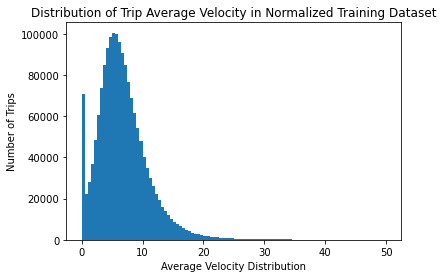

In [21]:
plt.hist(trimmed_velo["velocity"].tolist(), bins=100)
plt.xlabel('Average Velocity Distribution')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trip Average Velocity in Normalized Training Dataset')
plt.savefig("velocity_dist.png")

### Positional Heatmaps

In [22]:
initial = []
final = []
#allpos = []

for positions in coordinate_list:
    if(len(positions)<2):
        break
        
    initial.append([positions[0], positions[1]])
    final.append([positions[-2], positions[-1]])

#### Initial Positions

In [23]:
init_long = []
init_lat = []

for i in initial:
    if i[0] not in init_long:
        init_long.append(i[0])
    if i[1] not in init_lat:
        init_lat.append(i[1])
        
init_long_range = np.linspace(min(init_long), max(init_long), 20).tolist()
init_lat_range = np.linspace(min(init_lat), max(init_lat), 20).tolist()

values = [[0] * len(init_long_range)] * len(init_lat_range)

print(init_long_range)
print(init_lat_range)

for pos in initial:
    app_i = 0
    app_j = 0
    
    #print(pos)
    
    for i in range(0, len(init_lat_range), 1):

        if(pos[1] < init_lat_range[i]):
            app_i = i
            break
        
    for j in range(0, len(init_long_range), 1):
            
        if(pos[0] < init_long_range[j]):
            app_j = j
            break
            
    values[app_i][app_j] +=1

[-8.694846, -8.68512647368421, -8.67540694736842, -8.665687421052631, -8.655967894736841, -8.646248368421054, -8.636528842105264, -8.626809315789474, -8.617089789473685, -8.607370263157895, -8.597650736842105, -8.587931210526316, -8.578211684210526, -8.568492157894736, -8.558772631578947, -8.549053105263159, -8.53933357894737, -8.52961405263158, -8.51989452631579, -8.510175]
[41.008275, 41.02032742105263, 41.032379842105264, 41.044432263157894, 41.056484684210524, 41.068537105263154, 41.08058952631579, 41.09264194736842, 41.10469436842105, 41.11674678947368, 41.12879921052632, 41.14085163157895, 41.15290405263158, 41.16495647368421, 41.177008894736844, 41.18906131578947, 41.2011137368421, 41.21316615789473, 41.22521857894737, 41.237271]


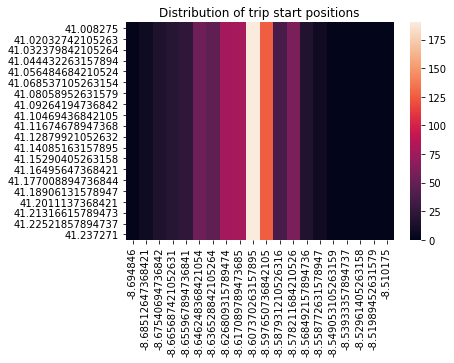

In [24]:
import seaborn

seaborn.heatmap(values, xticklabels = init_long_range, yticklabels = init_lat_range).set(title = "Distribution of trip start positions")
plt.savefig("sthm.png")

#### Destinations

In [25]:
final_long = []
final_lat = []

for i in final:
    if i[0] not in final_long:
        final_long.append(i[0])
    if i[1] not in final_lat:
        final_lat.append(i[1])
        
final_long_range = np.linspace(min(final_long), max(final_long), 20).tolist()
final_lat_range = np.linspace(min(final_lat), max(final_lat), 20).tolist()

fin_values = [[0] * len(final_long_range)] * len(final_lat_range)

for pos in initial:
    app_i = 0
    app_j = 0
    
    #print(pos)
    
    for i in range(0, len(final_lat_range), 1):

        if(pos[1] < final_lat_range[i]):
            app_i = i
            break
        
    for j in range(0, len(final_long_range), 1):
            
        if(pos[0] < final_long_range[j]):
            app_j = j
            break
            
    fin_values[app_i][app_j] +=1

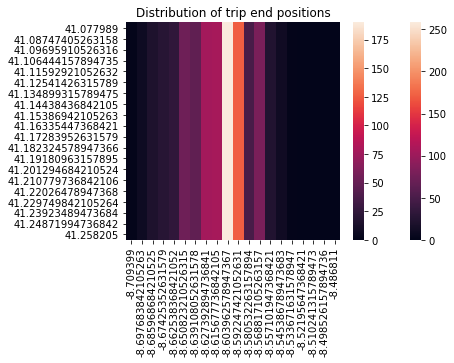

In [26]:
seaborn.heatmap(fin_values)
seaborn.heatmap(values, xticklabels = final_long_range, yticklabels = final_lat_range).set(title = "Distribution of trip end positions")
plt.savefig("ehm.png")

### Post Processing Dataset Sample

In [27]:
#trimmed_taxi_data = trimmed_taxi_data.drop(columns=['TRIP_ID', 'MISSING_DATA', 'DAY_TYPE', 'ORIGIN_CALL'])
trimmed_taxi_data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,7,1,0,0
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,7,1,0,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0


In [28]:
trimmed_velo.head()

,velocity
0,11.937889
1,14.555896
2,11.808893
3,5.345865
4,10.378641


# Visualization on Test Data

In [29]:
test_data = pd.read_csv("kaggle_data/test_public.csv")

#Display first 5 Lines
test_data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False


In [30]:
#Dataset Size
test_data.shape

(320, 8)

In [31]:
#Dataset Information Type
test_data.columns

Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA'],
      dtype='object')

In [32]:
#Find number of empty datacells by information type
test_data.isnull().sum()

TRIP_ID           0
CALL_TYPE         0
ORIGIN_CALL     248
ORIGIN_STAND    197
TAXI_ID           0
TIMESTAMP         0
DAY_TYPE          0
MISSING_DATA      0
dtype: int64